# CAC 40 Stock Price Forecast with ARIMA & LSTM

---

### Project Participant

* CAI Yutong
* EFREI Paris
* E-mail: yutong.cai@efrei.net

* WANG Shimeng
* EFREI Paris
* E-mail: shimeng.wang@efrei.net

### Reference Material

* CAC 40 data Donwload 1: https://cn.investing.com/indices/france-40-historical-data?cid=23658
* CAC 40 data Donwload 2: https://www.euronext.com/en/products/indices/FR0003500008-XPAR
* Jupyter Notebook Connect with HDFS: http://nbviewer.jupyter.org/github/ofermend/IPython-notebooks/blob/master/blog-part-1.ipynb
* Understand the LSTM Network: https://www.jianshu.com/p/9dc9f41f0b29
* Time Series Prediction with LSTM: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Data Science with Apache Hadoop: Predicting Airline Delays: https://fr.hortonworks.com/blog/data-science-apacheh-hadoop-predicting-airline-delays/

---

## PART 1. Import Dataset from HDFS and Data Preprocessing

### 1.1. Import Dataset from HDFS

In [1]:
import pandas as pd
import pydoop.hdfs as hdfs

In [2]:
# function to read HDFS file into dataframe using PyDoop

def read_csv_from_hdfs(path, cols, col_types=None):
    files = hdfs.ls(path);
    pieces = []
    for f in files:
        fhandle = hdfs.open(f)
        pieces.append(pd.read_csv(fhandle, names=cols, dtype=col_types))
        fhandle.close()
    return pd.concat(pieces, ignore_index=True)   

In [3]:
cols = ['Date', 'Open', 'High', 'Low', 'Close', 'Turnover'];

stock = read_csv_from_hdfs('bigdata/cac40.csv', cols)

### 1.1. Import Dataset from Local Hard Drive

* If you are not using HDFS, please import the csv file directly from the hard disk.
* Ignore this step if you have imported csv files from HDFS.

In [59]:
import pandas as pd

In [4]:
stock = pd.read_csv('cac40.csv')

### 1.2. Show Our Dataset

In [5]:
stock.shape

(4841, 6)

In [6]:
stock.head(10)

,Date,Open,High,Low,Close,Turnover
0,03/01/2000,6024.38,6102.12,5901.77,5917.37,-
1,04/01/2000,5922.23,5925.07,5657.20,5672.02,-
2,05/01/2000,5521.83,5589.50,5461.59,5479.70,-
3,06/01/2000,5485.93,5530.26,5388.85,5450.11,-
4,07/01/2000,5423.88,5561.69,5423.88,5539.61,-
5,10/01/2000,5625.82,5717.44,5616.98,5646.12,-
6,11/01/2000,5726.51,5726.51,5571.99,5613.90,-
7,12/01/2000,5541.23,5628.73,5536.50,5582.50,-
8,13/01/2000,5586.25,5682.27,5579.49,5633.24,-
9,14/01/2000,5669.14,5804.16,5664.71,5787.44,-


### 1.3. Change String Date to Datetime Format

In [7]:
stock['Date'] = pd.to_datetime(stock['Date'], format='%d/%m/%Y')
stock.head(10)

,Date,Open,High,Low,Close,Turnover
0,2000-01-03,6024.38,6102.12,5901.77,5917.37,-
1,2000-01-04,5922.23,5925.07,5657.20,5672.02,-
2,2000-01-05,5521.83,5589.50,5461.59,5479.70,-
3,2000-01-06,5485.93,5530.26,5388.85,5450.11,-
4,2000-01-07,5423.88,5561.69,5423.88,5539.61,-
5,2000-01-10,5625.82,5717.44,5616.98,5646.12,-
6,2000-01-11,5726.51,5726.51,5571.99,5613.90,-
7,2000-01-12,5541.23,5628.73,5536.50,5582.50,-
8,2000-01-13,5586.25,5682.27,5579.49,5633.24,-
9,2000-01-14,5669.14,5804.16,5664.71,5787.44,-


### 1.4. Set Datetime to Index

In [8]:
stock = stock.set_index('Date')
stock.head(10)

,Open,High,Low,Close,Turnover
Date,,,,,
2000-01-03,6024.38,6102.12,5901.77,5917.37,-
2000-01-04,5922.23,5925.07,5657.20,5672.02,-
2000-01-05,5521.83,5589.50,5461.59,5479.70,-
2000-01-06,5485.93,5530.26,5388.85,5450.11,-
2000-01-07,5423.88,5561.69,5423.88,5539.61,-
2000-01-10,5625.82,5717.44,5616.98,5646.12,-
2000-01-11,5726.51,5726.51,5571.99,5613.90,-
2000-01-12,5541.23,5628.73,5536.50,5582.50,-
2000-01-13,5586.25,5682.27,5579.49,5633.24,-


In [9]:
print('First Day: ', stock.index[0])
print('Last  Day: ', stock.index[-1])

First Day:  2000-01-03 00:00:00
Last  Day:  2018-12-04 00:00:00


### 1.5. Feature Selection & Data Resampling

In [10]:
stock_week = stock['Close'].resample('W-MON').mean() 

# 选取收盘价(Close)为样本数据
# 以周为单位周一开始重采样，以均值为计算标准

### 1.6. Split Dataset

In [11]:
stock_train = stock_week['2000':'2016']
stock_test = stock_week['2017':]

# 选择2000到2015年的股票数据作为训练集
# 选择2006年的股票数据作为测试集

### 1.7. Draw Training Data & Observation Data Trends¶

In [12]:
import matplotlib.pyplot as plt

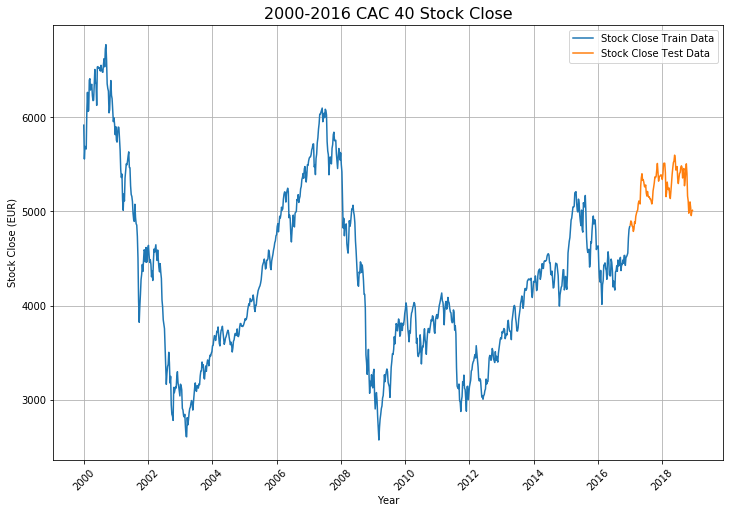

In [56]:
plt.figure(figsize=(12,8))

plt.plot(stock_train)
plt.plot(stock_test)

plt.title('2000-2016 CAC 40 Stock Close', size=16)
plt.xlabel('Year')
plt.ylabel('Stock Close (EUR)') 

plt.xticks(rotation=45)

plt.legend(['Stock Close Train Data','Stock Close Test Data'])

plt.grid(True)
plt.show()

* We can clearly see from the chart the impact of the 2003, 2008, 2012 financial crisis on stock market movements.

---

## Part 2. CAC 40 Stock Price Forecast with ARIMA

### 2.1. Make First Order Difference or Second Order Difference

#### 2.1.1. Make First Order Difference

In [14]:
stock_train_diff = stock_train.diff()
stock_train_diff = stock_train_diff.dropna()

# 做一阶差分，让数据变化趋势变得平稳

#### 2.2.2. Plot the Training Data After the First Order Difference

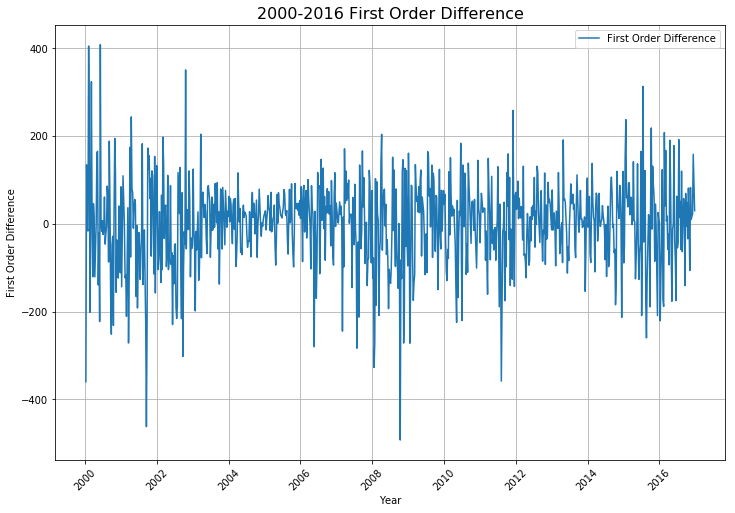

In [45]:
plt.figure(figsize=(12,8))
plt.plot(stock_train_diff)

plt.title('2000-2016 First Order Difference', size=16)
plt.xlabel('Year')
plt.ylabel('First Order Difference')

plt.xticks(rotation=45)

plt.legend(['First Order Difference'])

plt.grid(True)
plt.show()

# 根据观察一阶差分基本满足分析需求，不需再次进行二阶差分

### 2.2. Draw ACF&PACF Chart and Select Hyperparameter q&p

#### 2.2.1. Draw ACF Chart and Chose Hyperparameter q in MA Model

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

Text(0.5,1,'2000-2016 ACF')

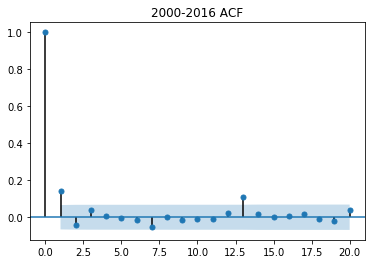

In [17]:
acf = plot_acf(stock_train_diff, lags=20)

plt.title("2000-2016 ACF")

#### 2.2.2. Draw PACF Chart and Chose Hyperparameter p in AR Model

In [18]:
from statsmodels.graphics.tsaplots import plot_pacf

Text(0.5,1,'2000-2016 PACF')

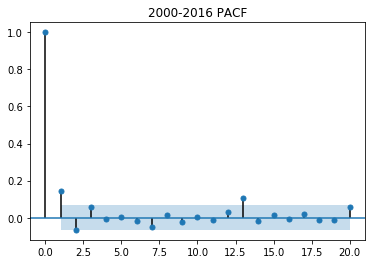

In [19]:
pacf = plot_pacf(stock_train_diff, lags=20)

plt.title("2000-2016 PACF")

### 2.3. Training ARIMA Model

In [20]:
from statsmodels.tsa.arima_model import ARIMA

In [21]:
model = ARIMA(stock_train, order=(1, 1, 1),freq='W-MON')
result = model.fit()
print(result.summary())

# order=(p,d,q)

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  886
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -5318.484
Method:                       css-mle   S.D. of innovations             97.890
Date:                Wed, 05 Dec 2018   AIC                          10644.967
Time:                        14:11:06   BIC                          10664.114
Sample:                    01-10-2000   HQIC                         10652.287
                         - 12-26-2016                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2687      3.681     -0.345      0.730      -8.484       5.947
ar.L1.D.Close    -0.3330      0.148     -2.256      0.024      -0.622      -0.044
ma.L1.D.Close     0.4923      0.136     

### 2.4. Use ARIMA Model to Predict CAC 40 Stock Price After 2016 (Weekly Forecast)

#### 2.4.1. Use ARIMA Model to Predict

In [22]:
predict_list=pd.Series([])

for i in range(len(stock_test)):
    model = ARIMA(stock_week[0:i+len(stock_train)], order=(1, 1, 1),freq='W-MON')
    result = model.fit()
    y_predict = result.predict(str(stock_week.index[i+len(stock_train)])[0:10], dynamic=True, typ='levels')
    predict_list = predict_list.append(y_predict)

/Users/caiyutong/anaconda3/envs/tensorflow/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


#### 2.4.2. Model evaluation

In [28]:
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error

In [29]:
y_hat = np.array(predict_list)
y_real = np.array(stock_test)

rmse = sqrt(mean_squared_error(y_real, y_hat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 69.550


#### 2.4.3. Draw the Predict Result

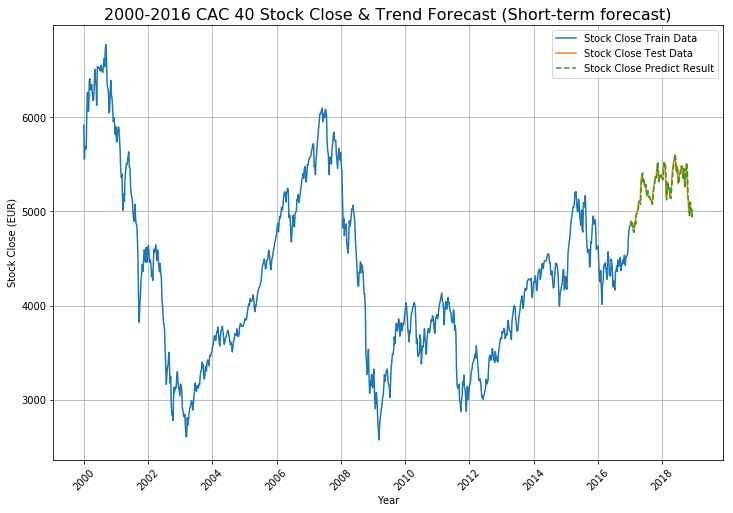

In [57]:
plt.figure(figsize=(12, 8))

plt.plot(stock_train)
plt.plot(stock_test)
plt.plot(predict_list,'--')

plt.title('2000-2016 CAC 40 Stock Close & Trend Forecast (Short-term forecast)', size=16)
plt.xlabel('Year')
plt.ylabel('Stock Close (EUR)')  

plt.xticks(rotation=45)

plt.legend(['Stock Close Train Data', 'Stock Close Test Data', 'Stock Close Predict Result'])

plt.grid(True)
plt.show()

---

## Part 3. CAC 40 Stock Price Forecast with LSTM

### 3.1. Prepare Data

In [31]:
all_data = stock_week.values.reshape(-1,1)
train_data = stock_train.values.reshape(-1,1)
test_data = stock_test.values.reshape(-1,1)

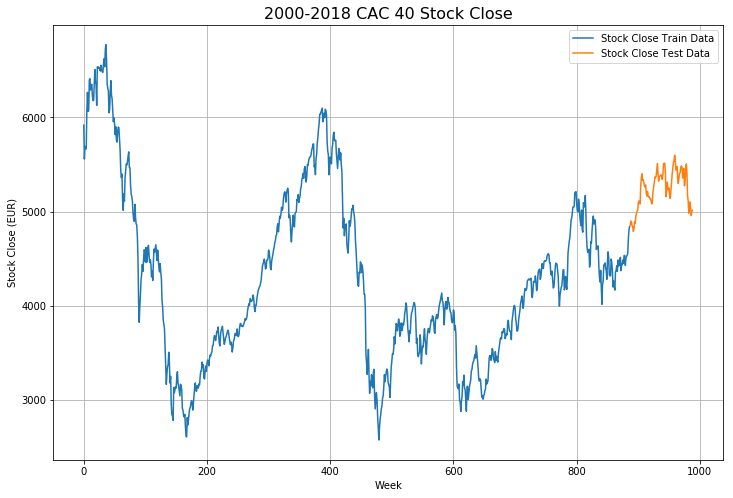

In [54]:
plt.figure(figsize=(12, 8))

trainDataPlot = np.empty_like(all_data)
trainDataPlot[:, :] = np.nan
trainDataPlot[0:len(train_data), :] = train_data

testDataPlot = np.empty_like(all_data)
testDataPlot[:, :] = np.nan
testDataPlot[len(train_data):len(all_data), :] = test_data

#plt.plot(all_data,"-")
#plt.plot(trainDataPlot,"--")
#plt.plot(testDataPlot,"--")

plt.plot(trainDataPlot,"-")
plt.plot(testDataPlot,"-")


#plt.legend(['Stock Close All Data', 'Stock Close Train Data', 'Stock Close Test Data'])
plt.legend(['Stock Close Train Data', 'Stock Close Test Data'])

plt.title('2000-2018 CAC 40 Stock Close', size=16)
plt.xlabel('Week')
plt.ylabel('Stock Close (EUR)')  

plt.grid(True)
plt.show()

### 3.2. Data Normalization

In [33]:
from sklearn.preprocessing import MinMaxScaler

In [34]:
minMaxScaler = MinMaxScaler(feature_range=(0, 1))

train_data_scale = minMaxScaler.fit_transform(train_data)
test_data_scale = minMaxScaler.transform(test_data)

### 3.3. Create Training Samples and Targets

In [35]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [36]:
# Window size: look_back

look_back = 3
X_train, Y_train = create_dataset(train_data_scale, look_back)
X_test, Y_test = create_dataset(test_data_scale, look_back)

### 3.4. Transform Data into LSTM Input Format

In [37]:
# reshape input to be [samples, time steps, features]

X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### 3.5. Create & Train LSTM Model

In [38]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

Using TensorFlow backend.


In [39]:
model = Sequential()

model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_lstm , Y_train, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
 - 3s - loss: 0.0174
Epoch 2/100
 - 2s - loss: 0.0012
Epoch 3/100
 - 2s - loss: 0.0011
Epoch 4/100
 - 2s - loss: 0.0011
Epoch 5/100
 - 2s - loss: 0.0010
Epoch 6/100
 - 2s - loss: 0.0010
Epoch 7/100
 - 2s - loss: 9.6853e-04
Epoch 8/100
 - 2s - loss: 9.3830e-04
Epoch 9/100
 - 2s - loss: 9.2616e-04
Epoch 10/100
 - 2s - loss: 8.8019e-04
Epoch 11/100
 - 2s - loss: 8.6857e-04
Epoch 12/100
 - 2s - loss: 8.4413e-04
Epoch 13/100
 - 2s - loss: 8.2065e-04
Epoch 14/100
 - 2s - loss: 8.1006e-04
Epoch 15/100
 - 2s - loss: 7.8029e-04
Epoch 16/100
 - 2s - loss: 7.7263e-04
Epoch 17/100
 - 2s - loss: 7.2515e-04
Epoch 18/100
 - 2s - loss: 7.0520e-04
Epoch 19/100
 - 2s - loss: 6.9675e-04
Epoch 20/100
 - 2s - loss: 6.6629e-04
Epoch 21/100
 - 2s - loss: 6.6903e-04
Epoch 22/100
 - 2s - loss: 6.9362e-04
Epoch 23/100
 - 2s - loss: 6.5781e-04
Epoch 24/100
 - 2s - loss: 6.4465e-04
Epoch 25/100
 - 2s - loss: 6.4117e-04
Epoch 26/100
 - 2s - loss: 6.2932e-04
Epoch 27/100
 - 2s - loss: 6.2086e-04
Epoch 2

### 3.6. Model Evaluation

In [40]:
# make predictions

train_predict = model.predict(X_train_lstm)
test_predict = model.predict(X_test_lstm)

In [41]:
# invert predictions

train_predict = minMaxScaler.inverse_transform(train_predict)
train_real = minMaxScaler.inverse_transform([Y_train])

test_predict = minMaxScaler.inverse_transform(test_predict)
test_real = minMaxScaler.inverse_transform([Y_test])

In [42]:
import math
from sklearn.metrics import mean_squared_error

In [43]:
# calculate root mean squared error

train_score = math.sqrt(mean_squared_error(train_real[0], train_predict[:,0]))
print('Train RMSE Score: %.2f' % (train_score))

test_score = math.sqrt(mean_squared_error(test_real[0], test_predict[:,0]))
print('Test  RMSE Score: %.2f' % (test_score))

Train RMSE Score: 98.14
Test  RMSE Score: 72.53


### 3.7. Draw Prediction Results

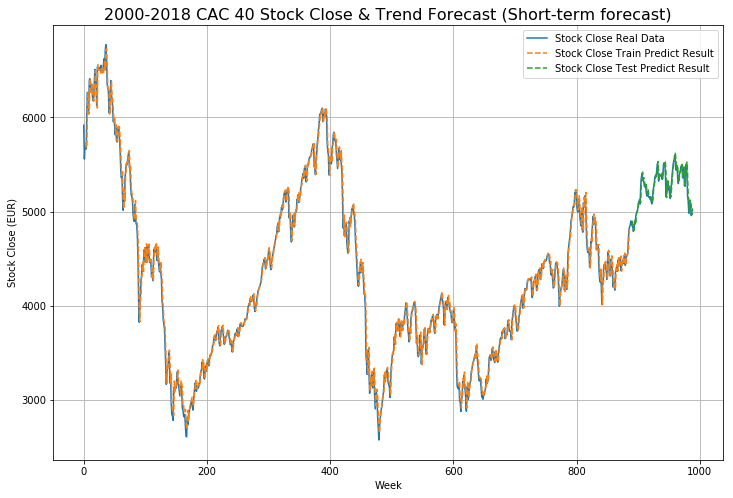

In [58]:
plt.figure(figsize=(12, 8))

trainPredictPlot = np.empty_like(all_data)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[0 + look_back:len(train_predict) + look_back, :] = train_predict

testPredictPlot = np.empty_like(all_data)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(2*look_back):len(all_data), :] = test_predict

plt.plot(all_data,"-")
plt.plot(trainPredictPlot,"--")
plt.plot(testPredictPlot,"--")

plt.legend(['Stock Close Real Data', 'Stock Close Train Predict Result', 'Stock Close Test Predict Result'])

plt.title('2000-2018 CAC 40 Stock Close & Trend Forecast (Short-term forecast)', size=16)
plt.xlabel('Week')
plt.ylabel('Stock Close (EUR)')  

plt.grid(True)
plt.show()

---

# -END-